In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skopt
from skopt import gp_minimize
from skopt.plots import plot_objective, plot_evaluations, plot_convergence, plot_gaussian_process

## Implement a one-dimension toy problem

In [2]:
# we will evaluate this from -5 to 5
def objective_func(x, noise=0.1):
    # x * cos(x) + sin(2*x)^2

    # gp_minimize expects a function that returns a scalar
    if type(x) in [list, np.array, np.ndarray]:
        x = x[0]

    return x * np.cos(x) + np.square(np.sin(2*x)) + noise * np.random.randn()

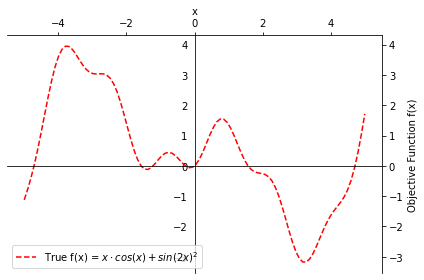

In [3]:
plt.close('all')

# what the true function looks like
np.random.seed(682)
x = np.linspace(-5, 5, 100)
true_y = [objective_func(x, noise=0) for x in x]

fig, ax = plt.subplots()
plt.plot(x, true_y, 'r--', label='True f(x) = $x \cdot cos(x) + sin(2x)^2$')
plt.xlabel("x")
plt.ylabel("Objective Function f(x)")
plt.legend(loc="lower left")
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
#ax.set_aspect(1)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Objective Function')

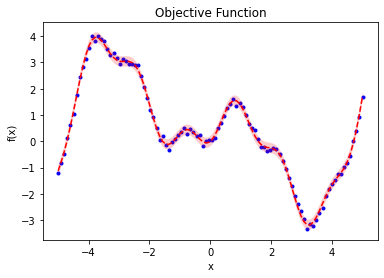

In [4]:
# what the true function looks like, with 95% CI band and sampled points with some noise N(0.3, 1)
np.random.seed(682)
x = np.linspace(-5, 5, 100)
noise = 0.1
true_y = [objective_func(x, noise=0) for x in x]
sample_y = [objective_func(x, noise=noise) for x in x]

ci_x = np.concatenate([x, x[::-1]])
ci_y = [*[y - 1.96*noise for y in true_y],
        *[y + 1.96*noise for y in true_y[::-1]]]

plt.plot(x, true_y, 'r--', label="Objective Function (unknown)")
plt.fill(ci_x, ci_y, alpha=.2, fc="r")
plt.scatter(x, sample_y, color="b", marker=".")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Objective Function")

In [5]:
# bayesian optimization with 100 evaluations
np.random.seed(682)
res = gp_minimize(objective_func,
                  dimensions=[(-5.,5.)],
                  n_calls=20,
                  n_random_starts=5,
                  acq_func="EI",
                  random_state=682,
                  #xi=0.01,  # controls how much improvement one wants over previous best
                  noise="gaussian")

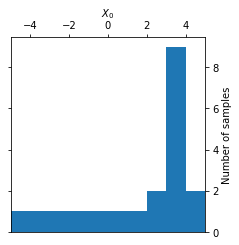

In [6]:
plot_evaluations(res, bins=10)
plt.gcf().set_size_inches(3,3)

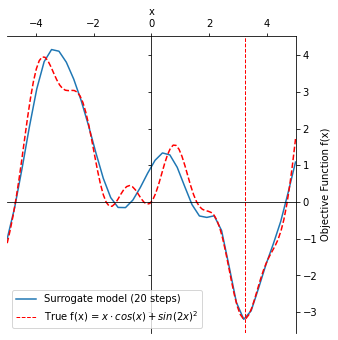

In [7]:
ax = plot_objective(res, size=4)
ax.set_label('Surrogate model (20 steps)')

ax2 = plt.plot(x, true_y, 'r--')
ax2[0].set_label('True f(x) = $x \cdot cos(x) + sin(2x)^2$')

plt.xlabel("x")
plt.ylabel("Objective Function f(x)")
plt.legend([ax._label, ax2[0]._label])
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
plt.tight_layout()
plt.gcf().set_size_inches(5,5)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

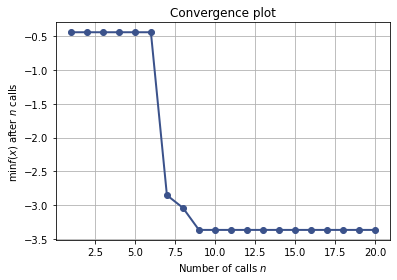

In [8]:
fig = plt.figure()
plot_convergence(res)

In [9]:
res.x[0]  # the minimum

3.2594185750779676

In [10]:
res.fun  # function value at minimum

-3.3698814476073937

In [11]:
res.x_iters  # x's tried along the way

[[1.9944343254110475],
 [4.8827460646945315],
 [4.7972495961104045],
 [-3.6866890927757177],
 [0.6475898867699312],
 [2.273696782837913],
 [2.9813469723955848],
 [3.4196571154160047],
 [3.2594185750779676],
 [-1.3385885373344126],
 [3.220116933469514],
 [-5.0],
 [3.89497845847065],
 [-0.4671858684364514],
 [3.2381079634864385],
 [-2.274210204897453],
 [3.236283818244484],
 [3.3412928804994753],
 [3.199554503205846],
 [3.3804939354499304]]

In [12]:
res.func_vals

array([-0.43845996,  0.81120564,  0.35022914,  3.89585257,  1.28463472,
       -0.39366279, -2.85518417, -3.04247405, -3.36988145,  0.01151544,
       -3.12189385, -1.00653934, -1.88643628,  0.27193239, -3.29433915,
        2.34916924, -3.06563796, -3.20269291, -3.1846957 , -3.00963706])

<AxesSubplot:title={'center':'x* = 3.2594, f(x*) = -3.3699'}, xlabel='x', ylabel='f(x)'>

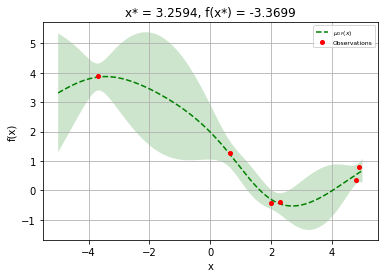

In [13]:
plt.figure()
plot_gaussian_process(res, n_calls=1)

<AxesSubplot:title={'center':'x* = 3.2594, f(x*) = -3.3699'}, xlabel='x', ylabel='f(x)'>

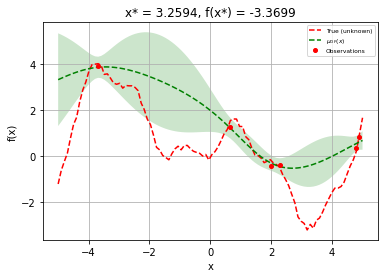

In [14]:
plt.figure()
plot_gaussian_process(res, n_calls=1, objective=objective_func, n_points=100)

In [15]:
def plot_bayes_iterations(res, start_iter, n_iters=5, noise=0.1, title=""):
    plt.figure(figsize=(8, 2 * n_iters))

    for i in range(n_iters):
        iter_num = start_iter + i
        plt.subplot(n_iters, 2, 2*i+1)
        show_legend = (i == 0)

        ax = plot_gaussian_process(res, n_calls=iter_num,
                                   #objective=(objective_func if i+1 == n_iters else None),
                                   #objective=objective_func,
                                   noise_level=noise,
                                   show_legend=show_legend, 
                                   show_title=False,
                                   show_acq_func=False)
        ax.plot(x, true_y, 'k--', linewidth=0.5)
        ax.set_ylim(-6,6)
        
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_title("Iteration {}".format(iter_num+1))
        # Plot EI(x)
        plt.subplot(n_iters, 2, 2*i+2)
        ax = plot_gaussian_process(res, n_calls=iter_num,
                                   show_legend=show_legend, show_title=False,
                                   show_mu=False, show_acq_func=True,
                                   show_observations=False,
                                   show_next_point=True)
        ax.set_title("Expected Improvement")
        ax.set_ylabel("")
        ax.set_xlabel("")

    plt.suptitle(title)
    plt.tight_layout()
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

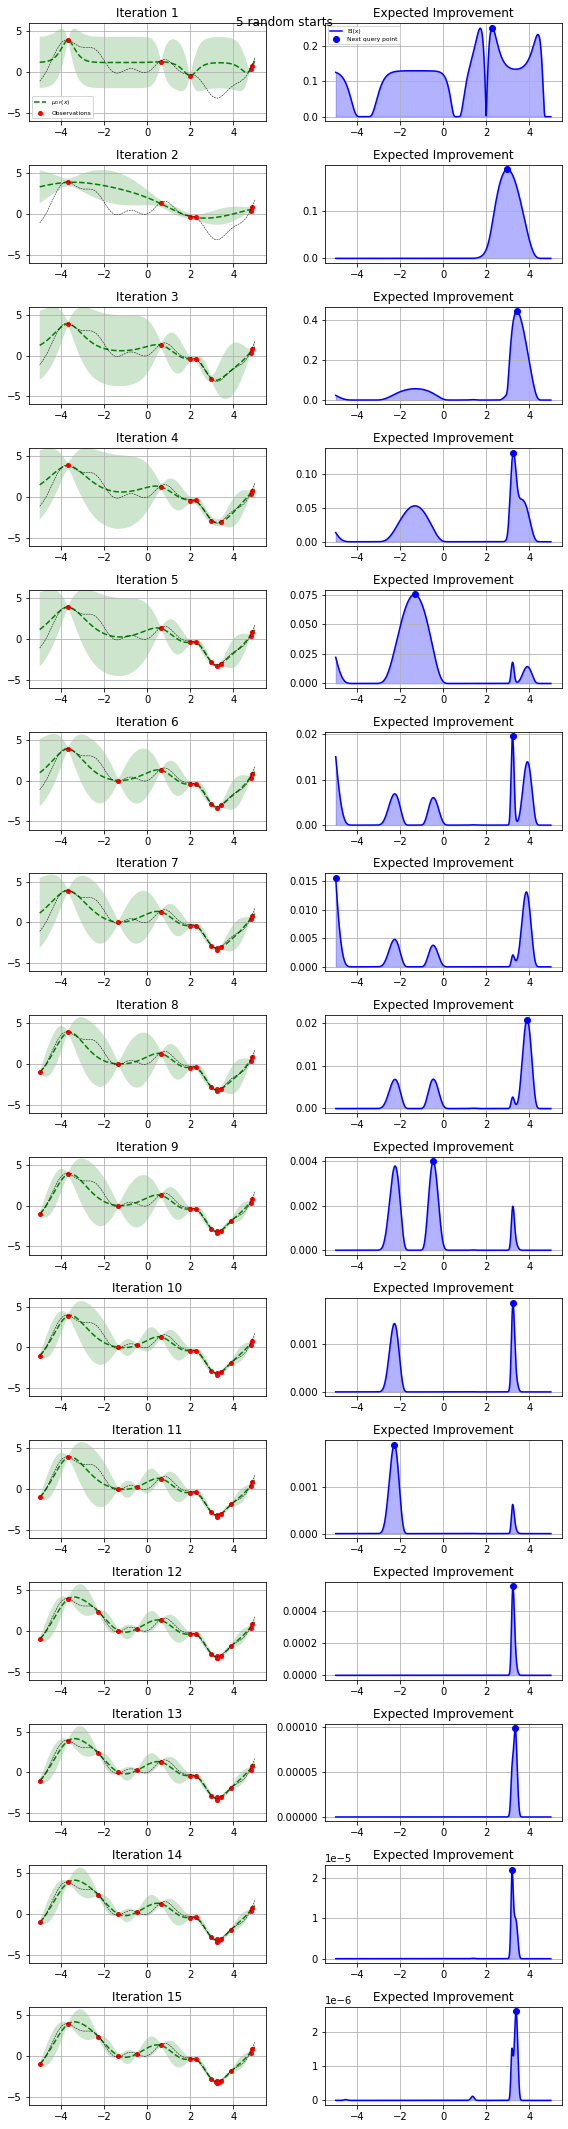

In [16]:
plot_bayes_iterations(res, start_iter=0, n_iters=15, title="5 random starts")

## What about with only 2 random starts?

Result: no difference, really

In [17]:
# bayesian optimization with 100 evaluations
np.random.seed(682)
res = gp_minimize(objective_func,
                  dimensions=[(-5.,5.)],
                  n_calls=20,
                  n_random_starts=2,
                  acq_func="EI",
                  random_state=682,
                  #xi=0.01,  # controls how much improvement one wants over previous best
                  noise="gaussian")

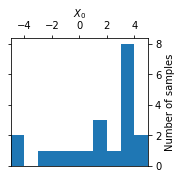

In [18]:
plot_evaluations(res, bins=10)
plt.tight_layout()
plt.gcf().set_size_inches(3,3)

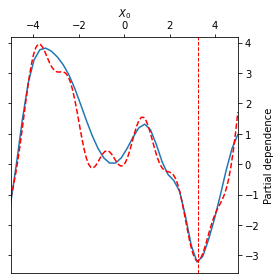

In [19]:
plot_objective(res, size=4)
plt.plot(x, true_y, 'r--', label="Objective Function (unknown)")
plt.tight_layout()

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

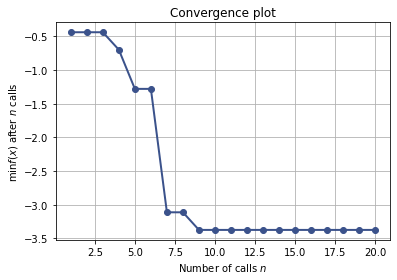

In [20]:
fig = plt.figure()
plot_convergence(res)